# Random Forest Model interpretation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [3]:
set_plot_sizes(12,14,16)

# 1. Load in data from last lesson (+ preliminaries)

In [4]:
PATH = "data/bulldozers/"

df_raw = pd.read_feather('tmp/raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [5]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [6]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print("RMSE Train\t\t RMSE Valid\t\tR2 train\t\tR2 valid\t OOB\n", res)
    #print(res)
    #print("%.2f" % res)

In [7]:
df_raw

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,2,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,2,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,0,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,0,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,1,S175,...,23,3,204,False,False,False,False,False,False,1248307200
5,1139255,10.184900,1001274,4605,121,3.0,2004,508.0,2,310G,...,18,3,353,False,False,False,False,False,False,1229558400
6,1139256,9.952278,772701,1937,121,3.0,1993,11540.0,0,790ELC,...,26,3,239,False,False,False,False,False,False,1093478400
7,1139261,10.203592,902002,3539,121,3.0,2001,4883.0,0,416D,...,17,3,321,False,False,False,False,False,False,1132185600
8,1139272,9.975808,1036251,36003,121,3.0,2008,302.0,2,430HAG,...,27,3,239,False,False,False,False,False,False,1251331200
9,1139275,11.082143,1016474,3883,121,3.0,1000,20700.0,1,988B,...,9,3,221,False,False,False,False,False,False,1186617600


# 2. Confidence based on tree variance

For model interpretation, there's no need to use the full dataset on each tree - using a subset will be both faster, and also provide better interpretability (since an overfit model will not provide much variance across trees). So we invoke `set_rf_samples` with a parameter that is *good enough*, and small enough to run fast (under 10 sec) and see.
The value (50000) is **per-tree**.

In [8]:
set_rf_samples(50000)

In [9]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

RMSE Train		 RMSE Valid		R2 train		R2 valid	 OOB
 [0.20580249789720947, 0.24937537766385415, 0.91148107942556433, 0.88894065303338865, 0.89447113665925893]


We saw how the model averages predictions across the trees to get an estimate - but how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions, instead of just the mean. This tells us the **relative** confidence of predictions - that is, for rows where the trees give very different results, you would want to be more cautious of using those results, compared to cases where they are more consistent. Using the same example as in the last lesson when we looked at bagging:

In [10]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,1]), np.std(preds[:,1])   #for one observation, the mean and the std

CPU times: user 1.38 s, sys: 28.3 ms, total: 1.41 s
Wall time: 1.41 s


(9.2466923579533287, 0.19498418328092557)

Above we have the prediction and the standard deviation of a single row.

Python (above in the comprehension) will loop through trees calculating each tree serially, which is **slow!** 
We can use parallel processing to speed this computation:
`parallel_trees` applies the function `get_preds` on $m$ (the RF model) in parallel to every tree, and returns a list. (Default n_jobs=8)

In [11]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,1]), np.std(preds[:,1])

CPU times: user 89 ms, sys: 155 ms, total: 244 ms
Wall time: 490 ms


(9.2466923579533287, 0.19498418328092557)

Clearly, (as std>0 ?), different trees are giving different estimates for the same auction price ([1]). 
To see how the prediction confidence varies, we can add columns for the deviation and prediction to our dataset.  

In [12]:
x = raw_valid.copy()   #get a copy of the data
x['pred_std'] = np.std(preds, axis=0)  #add column for predicted standard deviation
x['pred'] = np.mean(preds, axis=0) #add a column for the mean

In [13]:
x.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,pred_std,pred
389125,4364751,9.104980,2300944,665,172,1.0,1999,3726.0,2,KX1212,...,259,False,False,False,False,False,False,1284595200,0.326021,9.246734
389126,4364757,9.047821,1265434,12042,172,1.0,1996,5809.0,2,KX151,...,343,False,False,False,False,False,False,1291852800,0.194984,9.246692
389127,4364774,9.104980,2005935,9218,172,1.0,1993,0.0,-1,KX41,...,218,False,False,False,False,False,False,1281052800,0.200816,9.225628
389128,4364807,9.259131,2296707,668,172,1.0,2000,1789.0,2,KX612,...,349,False,False,False,False,False,False,1292371200,0.349764,9.284898
389129,4364811,9.104980,1403366,9219,172,1.0,1999,0.0,-1,KX61,...,161,False,False,False,False,False,False,1244592000,0.118681,9.131205


Lets examine a single variable (eg Enclosure) as a predictor, and do a histogram to see which values of this variable matter

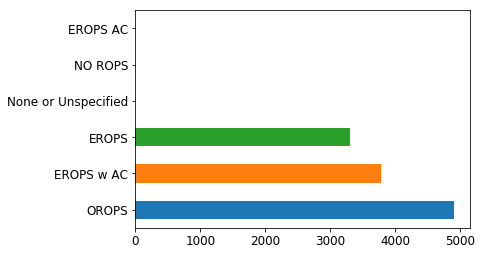

In [14]:
x.Enclosure.value_counts().plot.barh(); 

Now lets select 4 fields for a new dataframe view, `enc_summ`: 'Enclosure', 'SalePrice', 'pred', 'pred_std'

In [15]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.838404,0.271748
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.572827,0.271035
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.686310,0.223906


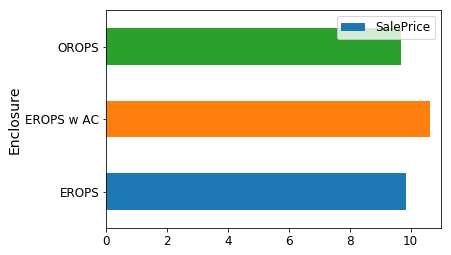

In [16]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)] 
enc_summ.plot(x='Enclosure', y='SalePrice', kind='barh', xlim=(0,11)); #barh indicates horizontal bars and label

Now the equivalent graph for the predictions, and the xerr shown as a black line for the standard deviation.  What is the parameter `alpha` ?  Not defined in `plot`

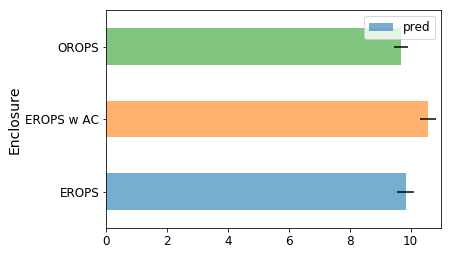

In [17]:
enc_summ.plot(x='Enclosure', y='pred', kind='barh', xerr='pred_std', alpha=0.6, xlim=(0,11)); 

*Question*: Why are the predictions nearly exactly right, but the error bars are quite wide?

Lets do something similar for `ProductSize`.

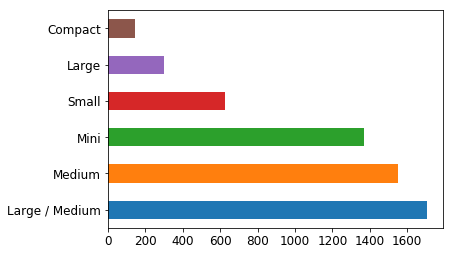

In [18]:
raw_valid.ProductSize.value_counts().plot.barh(); 

In [19]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.893225,0.372501
Large,10.470589,10.361811,0.359488
Large / Medium,10.691871,10.638749,0.301724
Medium,10.681511,10.626019,0.290022
Mini,9.535147,9.561131,0.249555
Small,10.324448,10.314821,0.315326


In [20]:
(summ.pred_std/summ.pred).sort_values(ascending=False)   #sort by ratio

ProductSize
Compact           0.037652
Large             0.034694
Small             0.030570
Large / Medium    0.028361
Medium            0.027294
Mini              0.026101
dtype: float64

The above sorted list shows that indeed for Compact and Large we have less confidence, and that is because we have seen fewer of those, as shown by the histogram above.

# 3. Feature importance

It's not enough to know that a model can make accurate predictions - we also want to know **how** it's making predictions. The most important way to see this is with **feature importance**.  That is, what features (columns) matter. JH always looks at this first.

`rf_feat_importance` (from fastai library) computes the "feature importance" given a model and the corresponding DF.
It builds a RF, then **randomly shuffle** a single column at a time. Now compute (without retraining) to get new predictions (after shuffling the variable), and start building a *little table*.
Compare the new predictions with the originals, and see how much worse the model predictions got after doing the re-shuffle. The importance is the difference, i.e., the bigger the difference, the bigger the importance of a variable.

Anecdote: Sometimes they find that the most important variable is **hugely** more important, and this is because it was a mistake (eg the variable was a different encoding of the dependent variable)

In [21]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
5,YearMade,0.170880
37,Coupler_System,0.130706
13,ProductSize,0.103827
14,fiProductClassDesc,0.080776
2,ModelID,0.053649
63,saleElapsed,0.049588
10,fiSecondaryDesc,0.048233
19,Enclosure,0.034307
8,fiModelDesc,0.033991
39,Hydraulics_Flow,0.033939


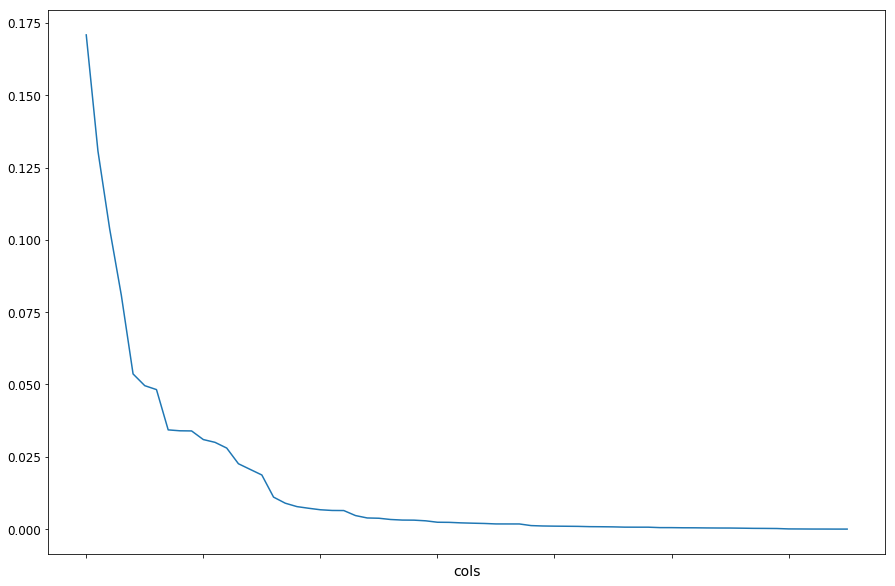

In [22]:
fi.plot('cols', 'imp', figsize=(15,10), legend=False);

In [23]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

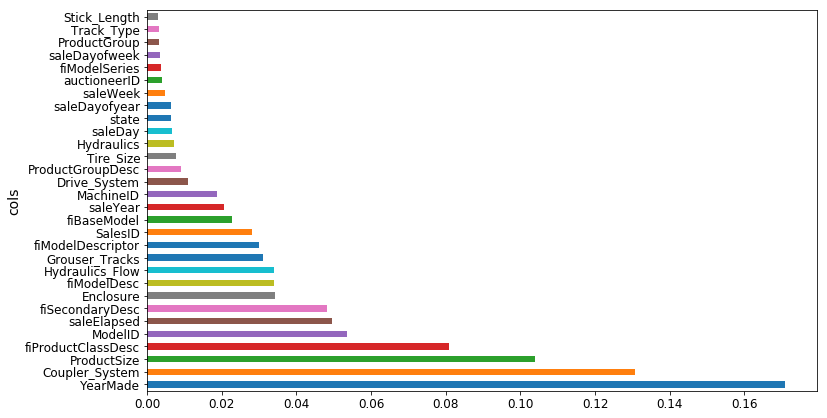

In [24]:
plot_fi(fi[:30]);

In [25]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)   #keep only those columns that are more significant than .005

23

In [26]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [27]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

RMSE Train		 RMSE Valid		R2 train		R2 valid	 OOB
 [0.20683858023129928, 0.2441331943902087, 0.91058756502908611, 0.89356079025866697, 0.89426590501923364]


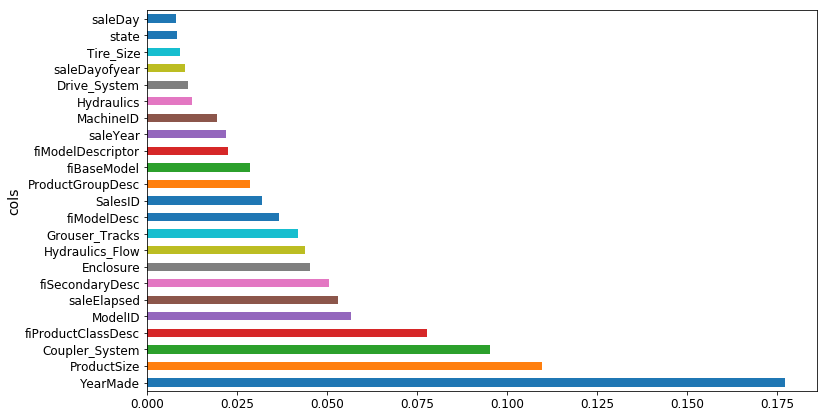

In [28]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

## One-hot encoding

Provide the RF the ability to discriminate in a way that it may improve the trees. For example, by noticing a particular value of a category in a single step, faster,  e.g. if it is or not a given value, the value unknown.  It may (or not) improve the RF.

`max_n_cat` defines the maximum number of categories to break into dummy values, instead
    of integer codes.

In [29]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

RMSE Train		 RMSE Valid		R2 train		R2 valid	 OOB
 [0.20728930111976848, 0.2548921337051005, 0.91019746410203917, 0.88397252543051019, 0.89246614140615776]


`proc_df` names the dummy valuables like originalname_value, e.g. ProductSize_Compact

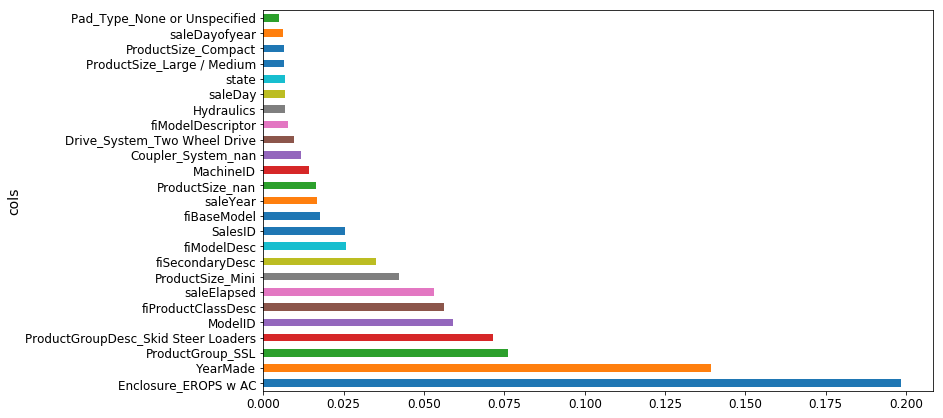

In [30]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

# 4. Removing redundant features

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. Let's try to remove redundent features.

In [31]:
from scipy.cluster import hierarchy as hc

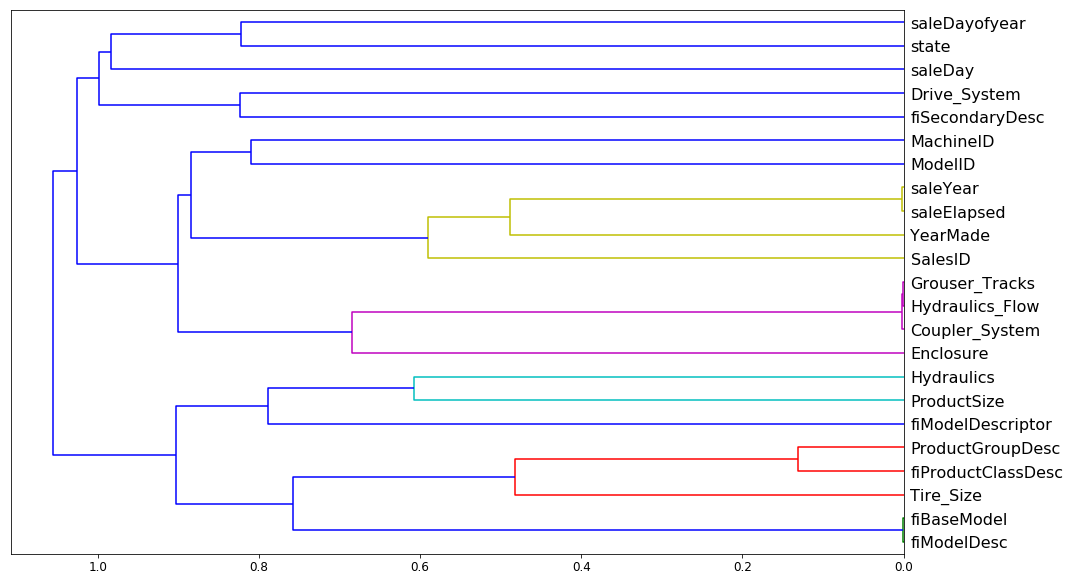

In [32]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

So there are 4 pairs of variables (e.g. Hydraulics_Flow and Grouser_Tracks), that are highly correlated, according to the above dendogram. Let's try removing some of these related features to see if the model can be simplified without impacting the accuracy.

In [33]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

Here's our baseline for accuracy using the oob score on the whole df.

In [34]:
get_oob(df_keep)

0.89012627177118231

Now we try removing each variable one at a time.

In [35]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.890003884436
saleElapsed 0.88682997117
fiModelDesc 0.889443335598
fiBaseModel 0.889755675644
Grouser_Tracks 0.889247837033
Coupler_System 0.889792225072


It looks like we can try one from each group for removal. Let's see what that does.

In [36]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.88865967627755871

Looking good! Let's use this dataframe from here. We'll save the list of columns so we can reuse it later.

In [37]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [38]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [39]:
keep_cols = np.load('tmp/keep_cols.npy')
df_keep = df_trn[keep_cols]

And let's see how this model looks on the full dataset.

In [40]:
reset_rf_samples()

In [41]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

RMSE Train		 RMSE Valid		R2 train		R2 valid	 OOB
 [0.12499044453199397, 0.22709993446810708, 0.96734960412073923, 0.9078952576982513, 0.90874867139861959]


So we got a model that is simple, and the score did not get significantly worse.

# 5. Partial dependence

In [42]:
from pdpbox import pdp
from plotnine import *    #must be pip installed

In [43]:
set_rf_samples(50000)

This next analysis will be a little easier if we use the 1-hot encoded categorical variables, so let's load them up again.

In [44]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

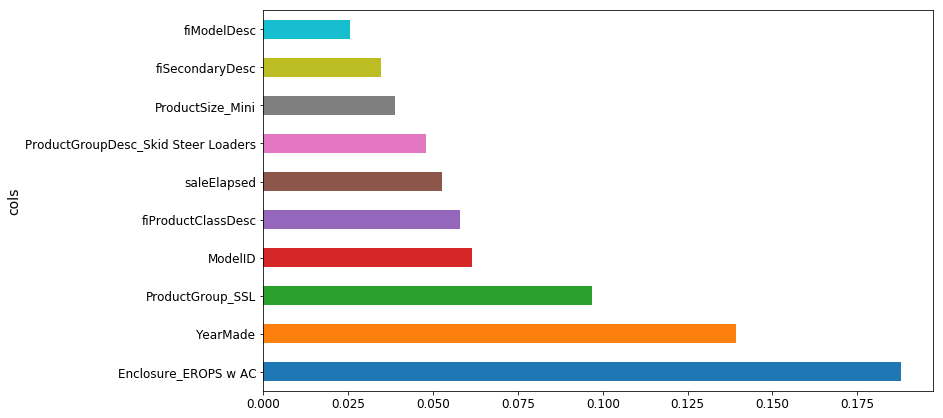

In [45]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

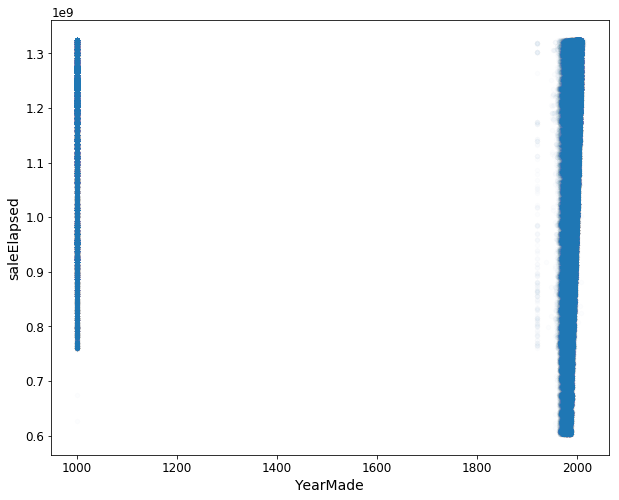

In [46]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

Lots of trucks built on year 1000?  :)  Those were probably the given default values when the YearMade where not known.  So below lets pick up a sample that only includes YearMade > 1930

In [47]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

the `loess` method below required to pip install scikit-misc

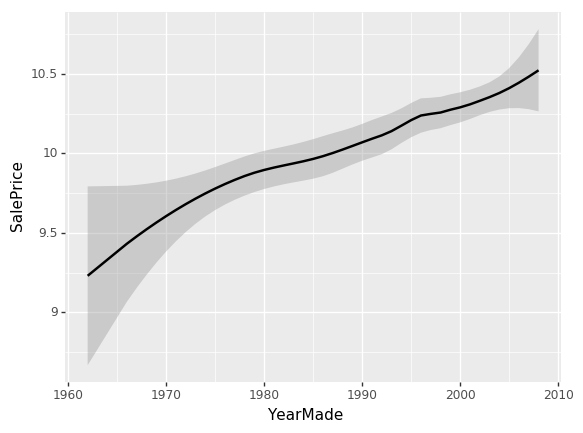

<ggplot: (-9223363268510551797)>

In [48]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

In [49]:
x = get_sample(X_train[X_train.YearMade>1930], 800)

In [50]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, 
                        cluster=clusters is not None, n_cluster_centers=clusters)

The partial dependence plot shows the marginal effect of a feature on the predicted outcome (J. H. Friedman 2001).  A partial dependence plot can show if the relationship between the target and a feature is linear, monotonic or something else
Calculate partial dependence by fixing the value of a column (eg YearMade), for each year (1960, 1961, ..., 2010). Then plot all the sample predictions for the values of YearMade. 
Yellow line is the average. Notice after 1990 is mostly a straight line.

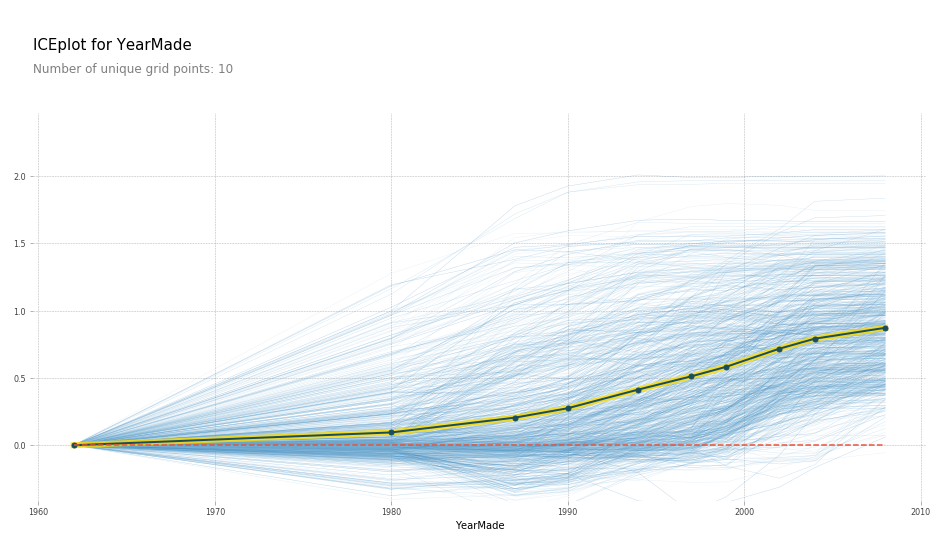

In [51]:
plot_pdp('YearMade')  

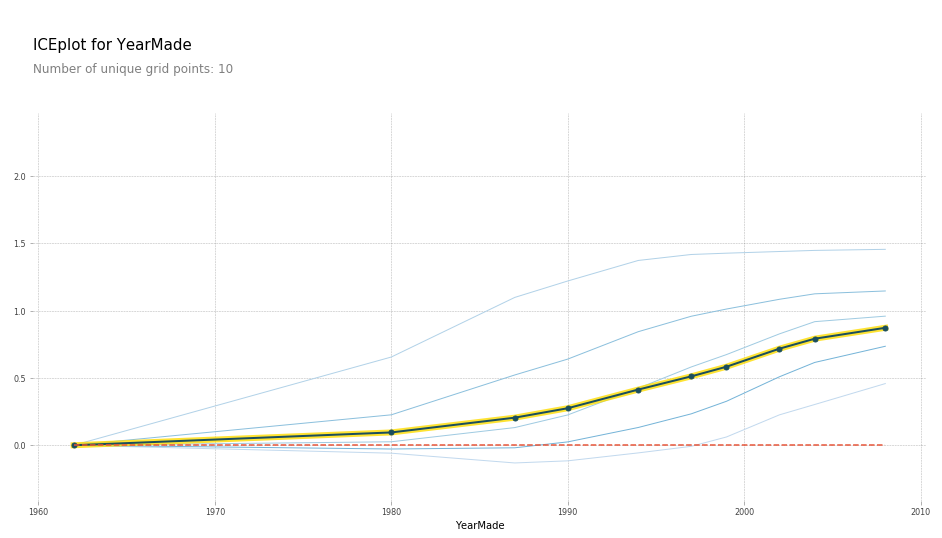

In [52]:
plot_pdp('YearMade', clusters=5)  # cluster the most common shapes we see...

At this point, JH suggests bringing in actual domain expertize to help interpret the data. After doing the feature importance, after all the above, is this the shape we expected?  We should have asked the question `what shape will be expect` before starting. The pdp graph shows the truth...

On how many features should we do pdp?  On all the important ones, particularly if they are **levers**, e.g. something we can change.

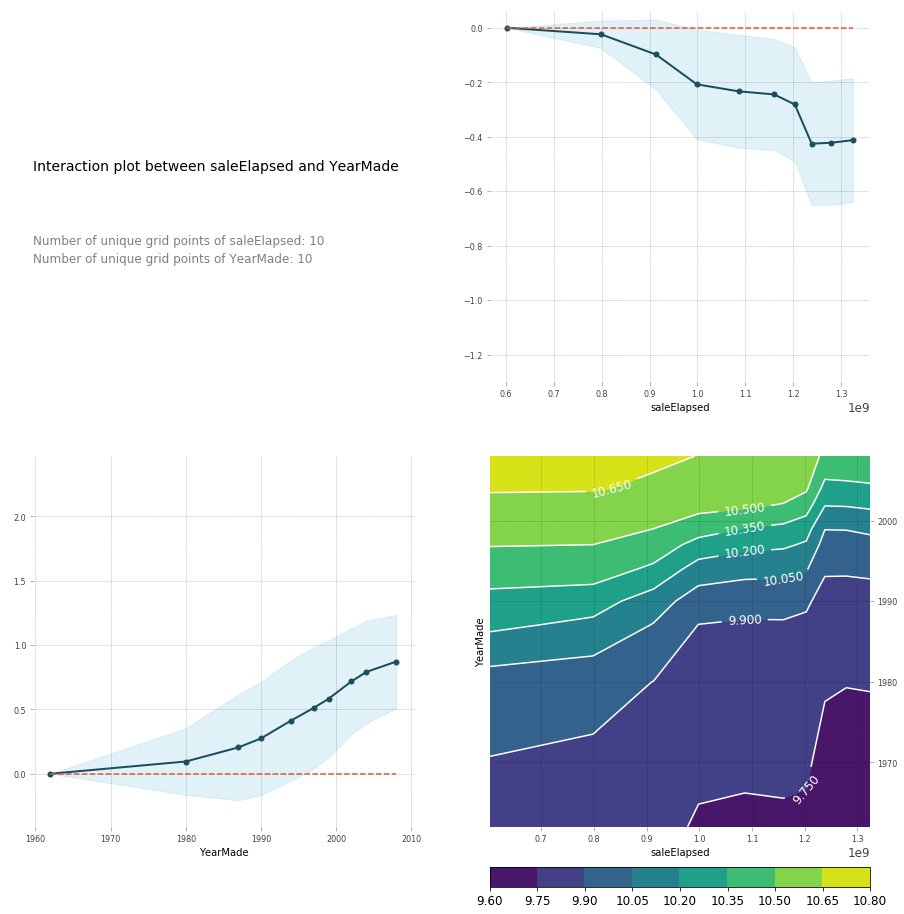

In [53]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, feats)
pdp.pdp_interact_plot(p, feats)

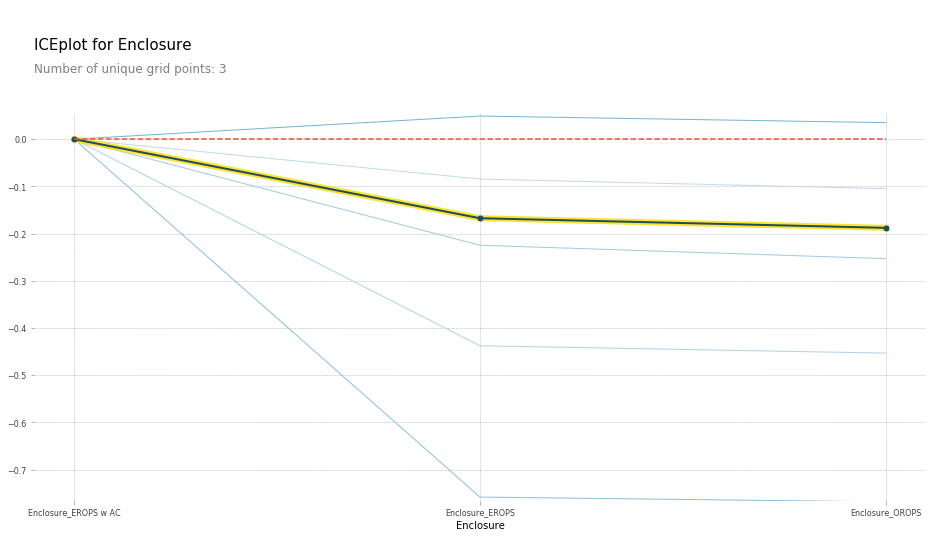

In [54]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

Compute the age.

In [55]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950   # avoid missing values
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

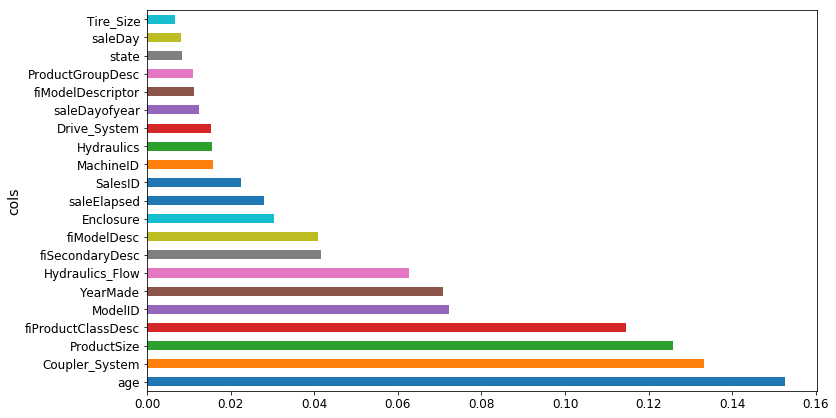

In [56]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

Now clearly age is the most important

# 6. Tree interpreter

Package for interpreting scikit-learn's decision tree and random forest predictions. Allows decomposing each prediction into bias and feature contribution components as described in http://blog.datadive.net/interpreting-random-forests/. For a dataset with n features, each prediction on the dataset is decomposed as prediction = bias + feature_1_contribution + ... + feature_n_contribution.

In [57]:
from treeinterpreter import treeinterpreter as ti    #Requires pip install treeinterpreter

In [58]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

We pick up **a row**, and interpret why the predictions are like they are (eg why the price is what it is, why is a patient going to be readmitted to the hospital, etc.)

In [59]:
row = X_valid.values[None,0]; row

array([[      1999,          0,          5,         17,        665, 1284595200,          0,          1,
              3232,          0,          0,    4364751,    2300944,          0,          4,          0,
                12,         16,         35,        259,         11]])

`ti.predict`(model, X, joint_contribution=False) given a particular instance (eg a quote for insurance)

Returns a triple (prediction, bias, feature_contributions), such
that prediction ≈ bias + feature_contribution

(`bias` is the root of the tree, the average price for everybody, `contributions` is how important is each of the variables)

In [60]:
prediction, bias, contributions = ti.predict(m, row) 

In [61]:
prediction[0], bias[0]   # For row 0, the predicted price and the average price.

(9.3805637433310274, 10.105459131133742)

`np.argsort`(a, axis=-1, kind='quicksort', order=None)

Returns the indices that would sort an array.

In [62]:
idxs = np.argsort(contributions[0])   

Below are the sorted contributions for row=0 in triples:
(variables, actual values, contributions)

In [63]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('ProductSize', 'Mini', -0.52301939582151324),
 ('age', 11, -0.11203889752963074),
 ('fiModelDesc', 'KX1212', -0.10827535344483011),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.10257487805559289),
 ('fiSecondaryDesc', nan, -0.044709233890950009),
 ('MachineID', 2300944, -0.03311718440735336),
 ('Enclosure', 'EROPS', -0.024645820445047217),
 ('fiModelDescriptor', nan, -0.022035488910385315),
 ('SalesID', 4364751, -0.017342236963541556),
 ('saleElapsed', 1284595200, -0.01698604146740652),
 ('saleDayofyear', 259, -0.015134128665013024),
 ('Tire_Size', nan, -0.012816000697619501),
 ('Hydraulics', 'Standard', -0.0042214726798108781),
 ('Drive_System', nan, 0.0082295272033948933),
 ('state', 'Ohio', 0.010987449178102172),
 ('saleDay', 16, 0.011353910885315255),
 ('ProductGroupDesc', 'Track Excavators', 0.014516751365443836),
 ('Hydraulics_Flow', nan, 0.031624209137086148),
 ('Coupler_System', nan, 0.062983665833363345),
 ('ModelID', 665, 0.078436172

In [64]:
contributions[0].sum()   # sum all contributions together

-0.7248953878027169

In [65]:
#!pip install waterfallcharts

https://github.com/chrispaulca/waterfall
Tried to use it but got funny unclear plot...

In [66]:
#import waterfall_chart

In [67]:
#contributions = [contributions[0][i][0] for i in range(len(contributions[0]))]
#colnames = df_keep.columns[0:-1].values
#my_plot=waterfall_chart.plot(colnames,contributions, rotation_value=90, threshold=0.3,formatting='{:,.3f}')

In [68]:
#colums=df_keep.columns[:8]
#conts = contributions[0,:8]

In [69]:
#my_plot=waterfall_chart.plot(colums,conts, rotation_value=90, threshold=0.3,formatting='{:,.3f}')

New heading

# 7. Extrapolation

RF can't extrapolate a linear time relationship...
We would like to avoid using time variables as predictors if there is an alternative that can work better in the future...
What is the difference between validation and training sets? If we understand this we can know which predictors have a strong temporal component and hence will be less relevant in the future.

So we create a random forest where the dependent variable is "is it in the validation set". 
Great trick in Kaggle to see if we can predict the test set...

In [70]:
df_ext = df_keep.copy()   #make a copy of the original DF
df_ext['is_valid'] = 1    # Add column for rows in validation set
df_ext.is_valid[:n_trn] = 0 # zero the column for rows in training set
x, y, nas = proc_df(df_ext, 'is_valid')  #use it as a dependent variable

In [71]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.99999252103459024

This is not a random sample because my validation sample can be predicted with a .9999 $R^2$

In [72]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
11,SalesID,0.828556
5,saleElapsed,0.110889
12,MachineID,0.048905
8,fiModelDesc,0.003268
0,YearMade,0.002042
4,ModelID,0.001523
19,saleDayofyear,0.001244
7,Enclosure,0.000841
1,Coupler_System,0.000629
16,Hydraulics,0.000609


Notice that `SalesID` is the most important, meaning that it has a strong temporal component, ie., SalesID increases over time.  `saleElapsed` also a good predictor.  Lets choose only the top 3 ('SalesID', 'saleElapsed', 'MachineID') as they are the only ones that are above .01 

In [73]:
feats=['SalesID', 'saleElapsed', 'MachineID']

lets take a look at values of these both in Train set and Validation set to confirm our suspicion.

In [74]:
(X_train[feats]/1000).describe()  

,SalesID,saleElapsed,MachineID
count,389125.000000,3.891250e+05,389125.000000
mean,1800.452485,1.084797e+06,1206.796148
std,595.627288,1.803913e+05,430.850552
min,1139.246000,6.009984e+05,0.000000
25%,1413.348000,9.666432e+05,1087.016000
50%,1632.093000,1.134605e+06,1273.859000
75%,2210.453000,1.234138e+06,1458.661000
max,4364.741000,1.325117e+06,2313.821000


In [75]:
(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.000000,1.200000e+04,12000.000000
mean,5786.967651,1.306609e+06,1578.049709
std,836.899608,2.497808e+04,589.497173
min,4364.751000,1.174522e+06,0.830000
25%,4408.580750,1.309219e+06,1271.225250
50%,6272.538500,1.316045e+06,1825.317000
75%,6291.792250,1.321402e+06,1907.858000
max,6333.342000,1.325203e+06,2486.330000


Clearly they are temporal, eg higher in validation... so lets drop them

In [76]:
x.drop(feats, axis=1, inplace=True)

In [77]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.97900405110626365

Improvement from .9999 but still bad.. we can still predict the validation set....   So now lets see which other variables are the most important.

In [78]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
17,age,0.234977
0,YearMade,0.187827
16,saleDayofyear,0.158097
4,ModelID,0.076207
7,fiModelDesc,0.064674
14,saleDay,0.059701
15,state,0.053411
3,fiProductClassDesc,0.034955
5,fiSecondaryDesc,0.023184
6,Enclosure,0.021985


In [79]:
set_rf_samples(50000)

In [80]:
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

Lets redo the RF to get a reference point

In [81]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

RMSE Train		 RMSE Valid		R2 train		R2 valid	 OOB
 [0.20816903556678845, 0.24690779983617783, 0.90943360386772687, 0.89112765104114222, 0.89292726615040863]


 Now lets try to remove each of the top feats, one by one and see how we do

In [82]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

SalesID
RMSE Train		 RMSE Valid		R2 train		R2 valid	 OOB
 [0.20862983299964297, 0.24506559523543192, 0.90903220937605267, 0.89274620601313093, 0.89281928442321812]
saleElapsed
RMSE Train		 RMSE Valid		R2 train		R2 valid	 OOB
 [0.21405676772392238, 0.25471431927535076, 0.90423810036803742, 0.88413435202468638, 0.88706404365508007]
MachineID
RMSE Train		 RMSE Valid		R2 train		R2 valid	 OOB
 [0.2064857756236697, 0.24447207489183298, 0.91089232650776142, 0.89326508932110948, 0.89519095251440484]
age
RMSE Train		 RMSE Valid		R2 train		R2 valid	 OOB
 [0.20858879498133567, 0.24604927602424617, 0.90906799304749097, 0.89188345545530057, 0.89250191830902614]
YearMade
RMSE Train		 RMSE Valid		R2 train		R2 valid	 OOB
 [0.20885719138060865, 0.2518643385069735, 0.90883383353727065, 0.88671267187575353, 0.89215838422113203]
saleDayofyear
RMSE Train		 RMSE Valid		R2 train		R2 valid	 OOB
 [0.20850294889051746, 0.24468407504101594, 0.90914282497688714, 0.89307989329707138, 0.89297739529117226]


So we see that for 3 variables ('SalesID', 'MachineID', 'saleDayofyear') the $R^2$ valid got better. Therefore, lets try to remove them and see how it affects.

In [83]:
reset_rf_samples()

In [84]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

RMSE Train		 RMSE Valid		R2 train		R2 valid	 OOB
 [0.13745266497879027, 0.21776549568038672, 0.96051418057345817, 0.9153111744293897, 0.90935855786469055]


$R^2$ valid got better! from .890 to .914, and, as expected $R^2$ validation was better that OOB

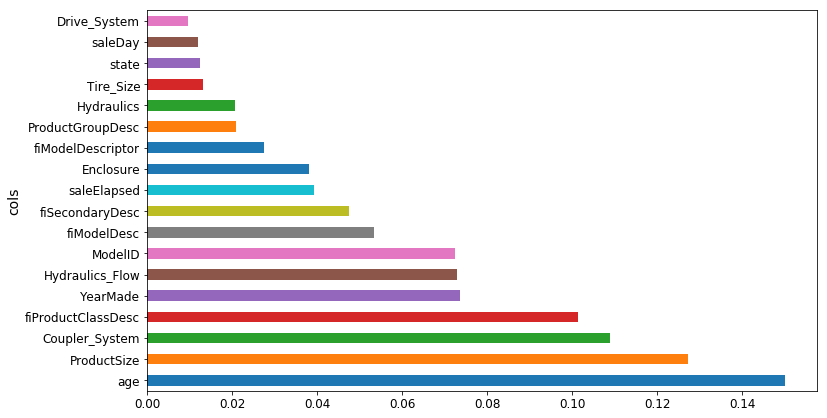

In [85]:
plot_fi(rf_feat_importance(m, X_train));

In [86]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

# Our final model!

Now lets try to do it with more trees, etc.

In [87]:
m = RandomForestRegressor(n_estimators=180, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 5min 35s, sys: 2.1 s, total: 5min 37s
Wall time: 38.2 s
RMSE Train		 RMSE Valid		R2 train		R2 valid	 OOB
 [0.08006179936051624, 0.21078468234952724, 0.98660367981425967, 0.92065381156891057, 0.91474955938559988]


So now we get a RMSE valid which is better (lower) that the Leaderboard Kaggle champion which was .21796